# Import libraries

In [1]:
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.dummy import DummyClassifier
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import joblib
warnings.filterwarnings('ignore')

# Functions

In [2]:
def print_conf_matrix(pipe: Pipeline):
    """ Display the confusion matrix for the given model

    Argument:
    pipe: Pipeline of the model
    """
    # Train and predict
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Display the classification report
    print(classification_report(y_test, y_pred))

    # Display the confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
    plt.title(f'{pipe.steps[1][0]}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


def plot_roc_curves(pipelines):
    """ Plots ROC curves for multiple pipelines.

    Args:
    pipelines: A list of Pipeline objects.
    """

    # Make a bigger figure
    plt.figure(figsize=(10, 6))

    for pipeline in pipelines:
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{pipeline.steps[1][0]} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2) # Create the threshold line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves of all models')
    plt.legend(loc="lower right")
    plt.show()


def build_model(models, X_train, X_test, y_train, y_test):
    model_performance = {}
    feature_importances_dict = {}

    for model in models:
        model_name = model.__class__.__name__
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        model_performance[model_name] = acc_score

        # Store feature importances for applicable models
        if hasattr(model, 'feature_importances_'):
            feature_importances = model.feature_importances_
            feature_importances_dict[model_name] = feature_importances

    return model_performance, feature_importances_dict


def get_params_for_model(params_dict):
    dicts_list = []
    for params in params_dict:
        dict = {key.split("__")[1]: value for key, value in params.items()}
        dicts_list.append(dict)
    return dicts_list

def plot_feature_importances(feature_importances, feature_names, model_name):
    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 8))
    plt.title(f'Feature Importances - {model_name}')
    sns.barplot(x=feature_importances[sorted_idx], y=np.array(feature_names)[sorted_idx])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Import data

In [3]:
df_master = pd.read_csv("../data/Customer-Churn-Records.csv")
df = df_master.copy()

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


# Exploratory data analysis

In [5]:
# Check if duplicates exist
df.duplicated().sum()

0

## Analyze columns types and nulls

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

> Comment:
* **RowNumber** column is basically index column,
* There is no null values in this dataset,
* Columns from the first glance seem to be in the correct type.

## Analyze numeric columns statistics

In [7]:
num_col_df = df.drop(["RowNumber", "CustomerId", "Exited"], axis=1)

In [8]:
num_col_df.describe().round(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Point Earned
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,650.529,38.922,5.013,76485.889,1.530,0.706,0.515,100090.240,0.204,3.014,606.515
std,96.653,10.488,2.892,62397.405,0.582,0.456,0.500,57510.493,0.403,1.406,225.925
min,350.000,18.000,0.000,0.000,1.000,0.000,0.000,11.580,0.000,1.000,119.000
25%,584.000,32.000,3.000,0.000,1.000,0.000,0.000,51002.110,0.000,2.000,410.000
50%,652.000,37.000,5.000,97198.540,1.000,1.000,1.000,100193.915,0.000,3.000,605.000
75%,718.000,44.000,7.000,127644.240,2.000,1.000,1.000,149388.248,0.000,4.000,801.000
max,850.000,92.000,10.000,250898.090,4.000,1.000,1.000,199992.480,1.000,5.000,1000.000


In [9]:
df.NumOfProducts.unique()

array([1, 3, 2, 4])

In [10]:
df.HasCrCard.unique()

array([1, 0])

In [11]:
df.IsActiveMember.unique()

array([1, 0])

In [12]:
df.Complain.unique()

array([1, 0])

In [13]:
df["Satisfaction Score"].unique()

array([2, 3, 5, 4, 1])

> Comment:
* Excluding **RowNumber** and **CustomerId** columns, other columns seem to not have abnormal values.
* **NumOfProducts** and **Statisfaction Score** columns are categorical in numeric.
* **HasCrCard**, **IsActiveMember** and **Complain** columns are binary in numeric.

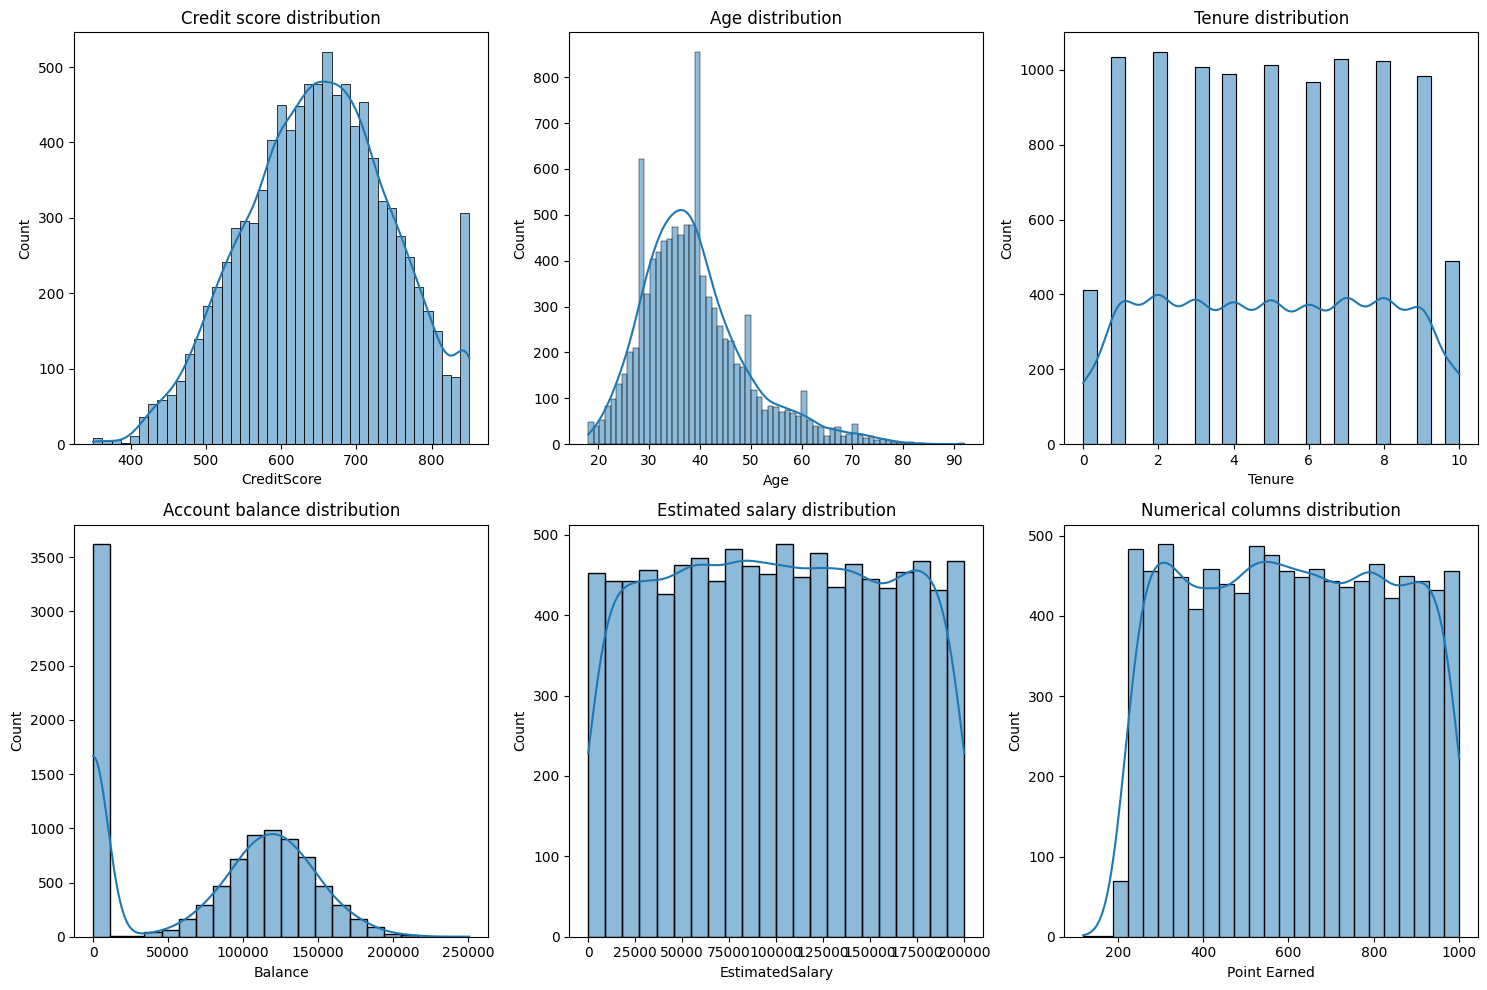

In [14]:
plt.figure(figsize=(15,10))

plt.subplot(2, 3, 1)
sns.histplot(data=df, x="CreditScore", kde=True)
plt.title("Credit score distribution")

plt.subplot(2, 3, 2)
sns.histplot(data=df, x="Age", kde=True)
plt.title("Age distribution")

plt.subplot(2, 3, 3)
sns.histplot(data=df, x="Tenure", kde=True)
plt.title("Tenure distribution")

plt.subplot(2, 3, 4)
sns.histplot(data=df, x="Balance", kde=True)
plt.title("Account balance distribution")

plt.subplot(2, 3, 5)
sns.histplot(data=df, x="EstimatedSalary", kde=True)
plt.title("Estimated salary distribution")

plt.subplot(2, 3, 6)
sns.histplot(data=df, x="Point Earned", kde=True)
plt.title("Point Earned distribution")

plt.tight_layout()
plt.title("Numerical columns distribution")
plt.show()

> Comment: Only Credit score has a normal distribution, in model training phase, features scaling need to be applied if we use models that are sensitive to the scaling.

## Analyze "string" columns

In [15]:
df.Geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [16]:
df.Gender.unique()

array(['Female', 'Male'], dtype=object)

In [17]:
df["Card Type"].unique()

array(['DIAMOND', 'GOLD', 'SILVER', 'PLATINUM'], dtype=object)

> Comment:
* There are only three countries, which may introduce bias in the model training.
* Only two genders found in the dataset, which is fine.
* 4 types of card which are in normal state.

## Analyze target column

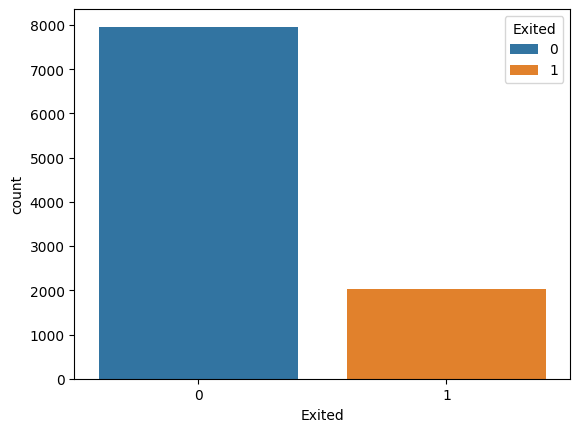

In [18]:
sns.countplot(data=df, x="Exited", hue="Exited")
plt.show()

> Comment: There is an imbalance in the target, which may cause bias in the model training phase.

## Analyze the relationship between columns and the target.

Since we are doing a churn prediction application and the target is the **Exited** column, we want to know whether there is a linearly separable relationship.

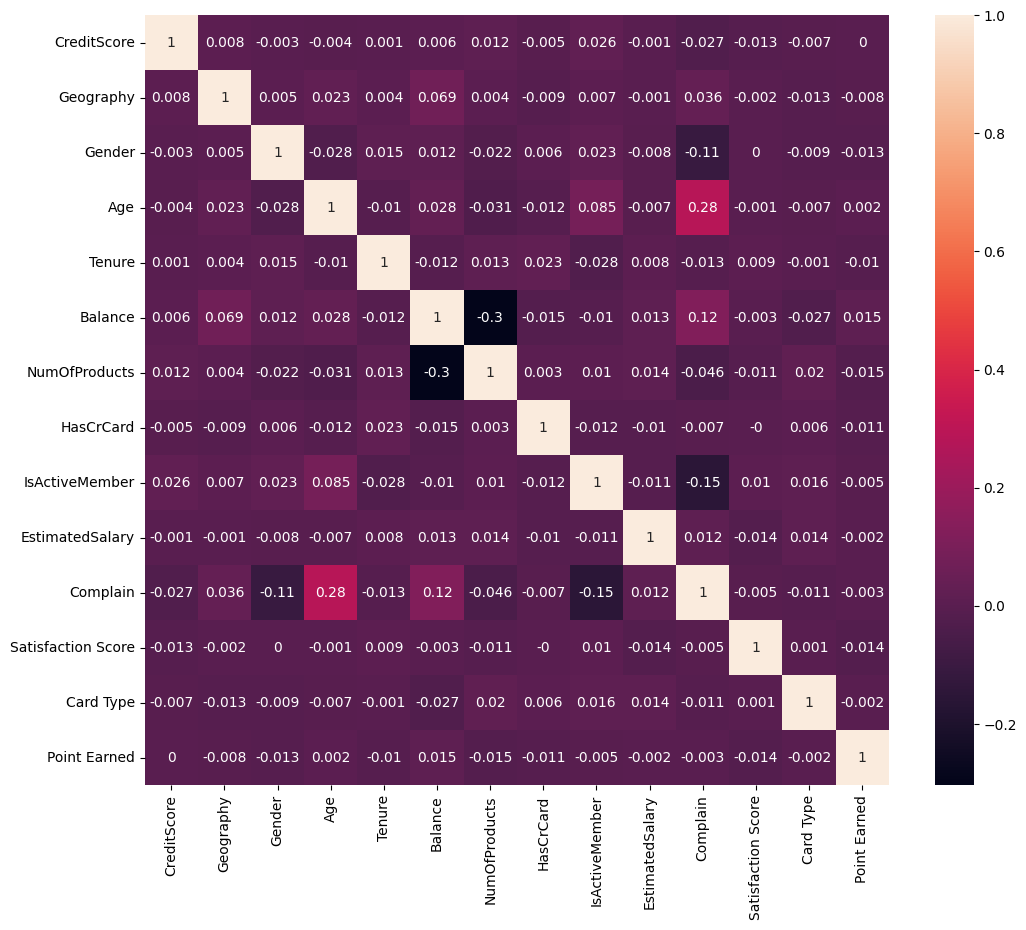

In [19]:
no_target_corr = df.copy().drop(["RowNumber", "CustomerId", "Surname", "Exited"], axis=1)

no_target_corr.Gender = no_target_corr.Gender.astype("category").cat.codes
no_target_corr.Geography = no_target_corr.Geography.astype("category").cat.codes
no_target_corr["Card Type"] = no_target_corr["Card Type"].astype("category").cat.codes

plt.figure(figsize=(12,10))
sns.heatmap(no_target_corr.corr().round(3), annot=True)
plt.show()

In [20]:
for_corr_df = df.copy().drop(["RowNumber", "CustomerId", "Surname"], axis=1)

for_corr_df.Gender = for_corr_df.Gender.astype("category").cat.codes
for_corr_df.Geography = for_corr_df.Geography.astype("category").cat.codes
for_corr_df["Card Type"] = for_corr_df["Card Type"].astype("category").cat.codes

for_corr_df.corr().abs()["Exited"].sort_values(ascending=False)

Exited                1.000000
Complain              0.995693
Age                   0.285296
IsActiveMember        0.156356
Balance               0.118577
Gender                0.106267
NumOfProducts         0.047611
Geography             0.035712
CreditScore           0.026771
Tenure                0.013656
EstimatedSalary       0.012490
Card Type             0.010861
HasCrCard             0.006976
Satisfaction Score    0.005849
Point Earned          0.004628
Name: Exited, dtype: float64

> Comment:
* There is no significant correlation between columns excluding the target.
* Our target most correlated with **Complain** column

# Model training

In [21]:
# For api
df.rename(columns={'Satisfaction Score': 'SatisfactionScore', 'Card Type': 'CardType', 'Point Earned': 'PointEarned'}, inplace=True)
df.to_csv('../data/customer_churn_records.csv', index=False)

## Isolate features and target

In [22]:
train = pd.read_csv('../data/customer_churn_records.csv')
train.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,SatisfactionScore,CardType,PointEarned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [23]:
features = train.drop(["RowNumber", "CustomerId", "Geography", "Surname", "Complain", "Exited"], axis=1)
target = train.Exited

In [24]:
features_names = features.columns

In [25]:
features.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,SatisfactionScore,CardType,PointEarned
0,619,Female,42,2,0.00,1,1,1,101348.88,2,DIAMOND,464
1,608,Female,41,1,83807.86,1,0,1,112542.58,3,DIAMOND,456
2,502,Female,42,8,159660.80,3,1,0,113931.57,3,DIAMOND,377
3,699,Female,39,1,0.00,2,0,0,93826.63,5,GOLD,350
4,850,Female,43,2,125510.82,1,1,1,79084.10,5,GOLD,425


In [26]:
target.unique()

array([1, 0])

## Split dataset

In [27]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.2, shuffle=True, stratify=target, random_state=42)

print(X_train.shape)
print(X_test.shape)

(8000, 12)
(2000, 12)


## Feature processing

### Prepare Transfomer objets

In [28]:
binary_cols = ["Gender"]
ordinal_cols = ["CardType"]
numeric_cols = ["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary", "PointEarned"]

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(), binary_cols),
        ('ordinal', OrdinalEncoder(categories=[["SILVER", "GOLD", "PLATINUM", "DIAMOND"]]), ordinal_cols),
        ('scaler', StandardScaler(), numeric_cols)
    ], remainder="passthrough")

In [29]:
# For API usage
X_train_processed = preprocessor.fit_transform(X_train)
joblib.dump(preprocessor, '../notebook/preprocessor.joblib')

X_test_processed = preprocessor.transform(X_test)

### Resampling

In [30]:
smote = SMOTE(random_state=42, n_jobs=-1)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

## Baseline models

In [31]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)

print(f"Dummy classifier accuracy: {accuracy_score(y_test, dummy_pred)}")

Dummy classifier accuracy: 0.796


> Comment: Created a dummy model as a baseline to compare the other algorithms. The baseline for this classification task is to predict the mode of the target variable. In this case, since the churn vs non-churn distribution is 1 to 4, if we predict randomly then 80% of the time a customer would be classified as non-churner.

## Comparison models

### Train models using pipeline without resampling

Trained 4 models for educational purposes.

In [31]:
logistic_reg_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('log_classifier', LogisticRegression(random_state=42))
])

random_forest_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf_classifier', RandomForestClassifier(random_state=42))
])

gradient_boosting_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('boost_classifier', GradientBoostingClassifier(random_state=42))
])

xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb_classifier', XGBClassifier())
])

In [32]:
logistic_cv = cross_val_score(logistic_reg_pipe, features, target, cv=5, scoring="accuracy")
rf_cv = cross_val_score(random_forest_pipe, features, target, cv=5, scoring="accuracy")
grb_cv = cross_val_score(gradient_boosting_pipe, features, target, cv=5, scoring="accuracy")
xgb_cv = cross_val_score(xgb_pipe, features, target, cv=5, scoring="accuracy")

#### Model evaluation

##### Cross validation

In [33]:
names = ["Logistic Regression", "Random Forest", "Gradient Boosting", "XGBoost"]
cv_scores = [logistic_cv, rf_cv, grb_cv, xgb_cv]
mean_accs = [cv_scores.mean() for cv_scores in cv_scores]

result_df = pd.DataFrame({
        "Model name": names,
        "Mean Accuracy": mean_accs
})

result_df.set_index("Model name", inplace=True)
result_df

,Mean Accuracy
Model name,
Logistic Regression,0.8063
Random Forest,0.8557
Gradient Boosting,0.8578
XGBoost,0.8493


> Comment: All 4 improved significantly compared to the dummy model. **Gradient Boosting** model performed the best.

##### Hold out method

###### Logistic Regression

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1592
           1       0.58      0.15      0.24       408

    accuracy                           0.80      2000
   macro avg       0.70      0.56      0.56      2000
weighted avg       0.77      0.80      0.76      2000


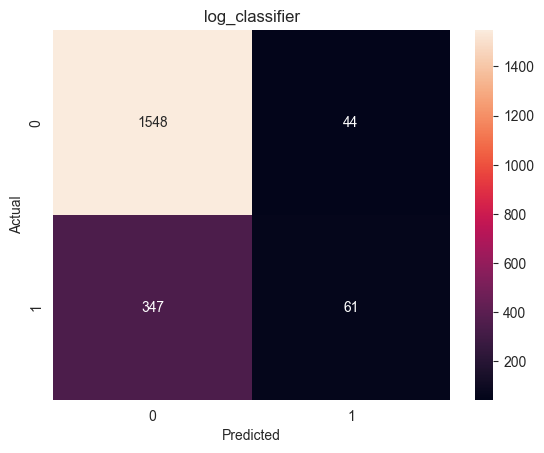

In [34]:
print_conf_matrix(logistic_reg_pipe)

###### Random Forest

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1592
           1       0.77      0.44      0.56       408

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000


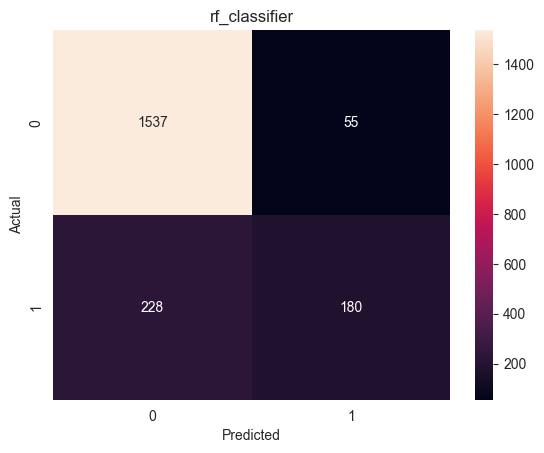

In [35]:
print_conf_matrix(random_forest_pipe)

###### Gradient Boosting

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1592
           1       0.76      0.45      0.57       408

    accuracy                           0.86      2000
   macro avg       0.81      0.71      0.74      2000
weighted avg       0.85      0.86      0.84      2000


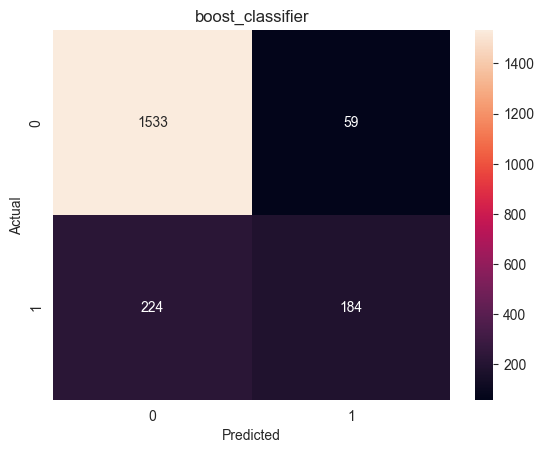

In [36]:
print_conf_matrix(gradient_boosting_pipe)

###### XGBoost

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1592
           1       0.66      0.48      0.55       408

    accuracy                           0.84      2000
   macro avg       0.77      0.71      0.73      2000
weighted avg       0.83      0.84      0.83      2000


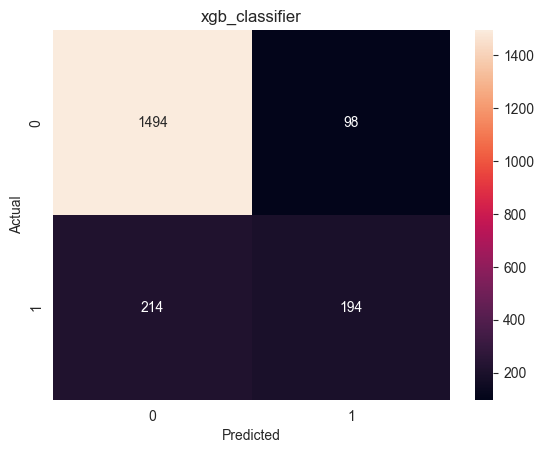

In [37]:
print_conf_matrix(xgb_pipe)

##### ROC curves

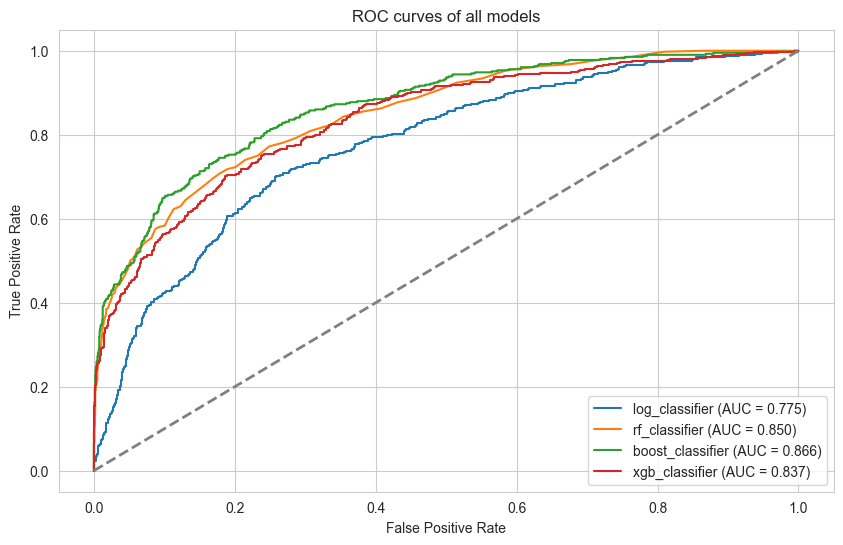

In [38]:
pipelines = [logistic_reg_pipe, random_forest_pipe, gradient_boosting_pipe, xgb_pipe]
plot_roc_curves(pipelines)

### Train models using resampling

#### Model fitting

In [39]:
log_reg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
grad_boost = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier()

In [40]:
models = [log_reg, rf, grad_boost, xgb]

perf_dict, feats_imp = build_model(models, X_train_resampled, X_test_processed, y_train_resampled, y_test)

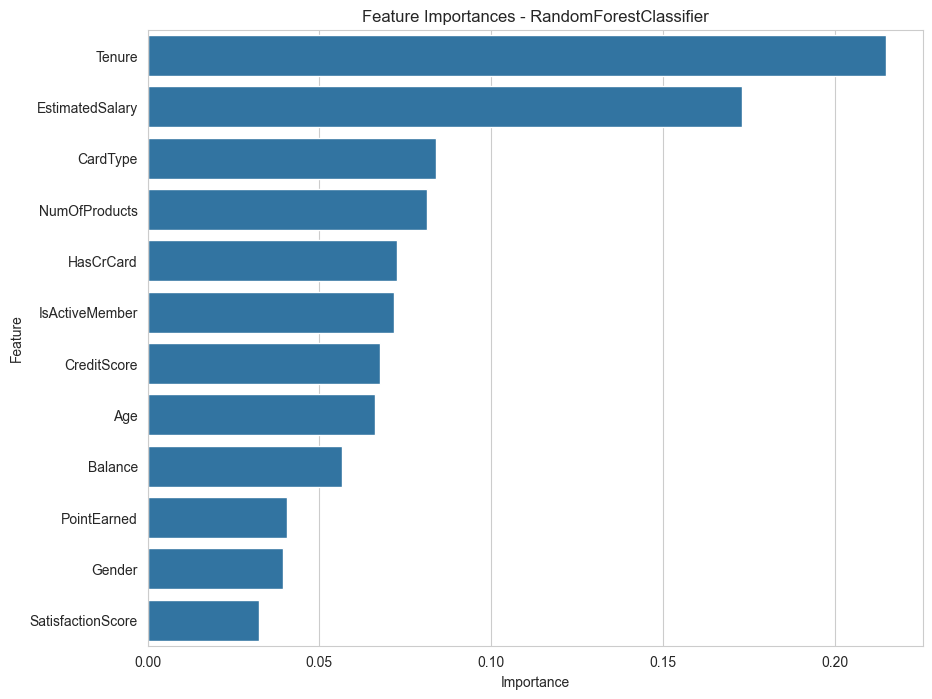

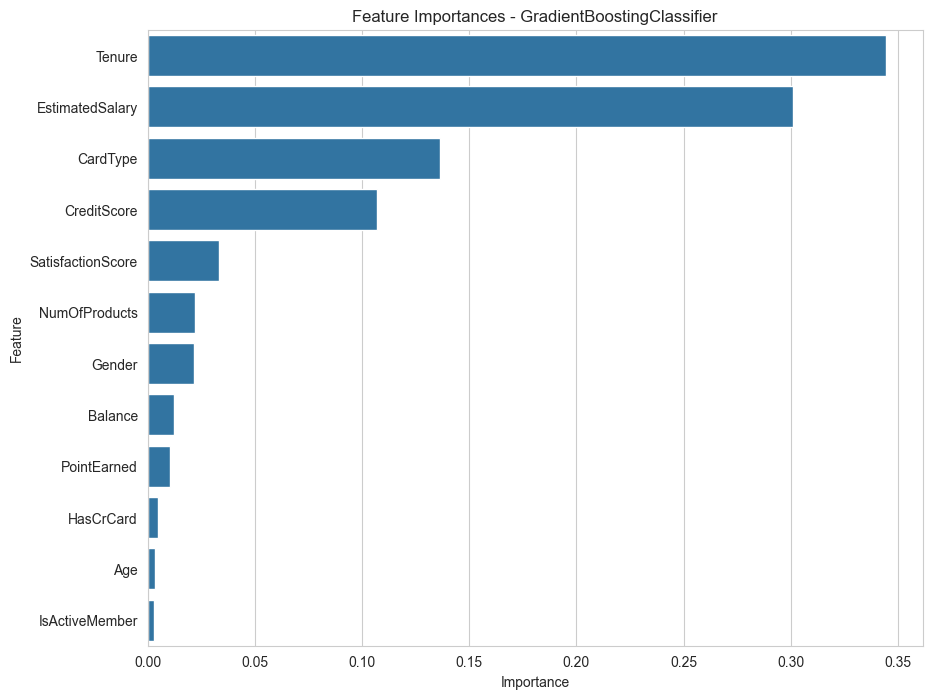

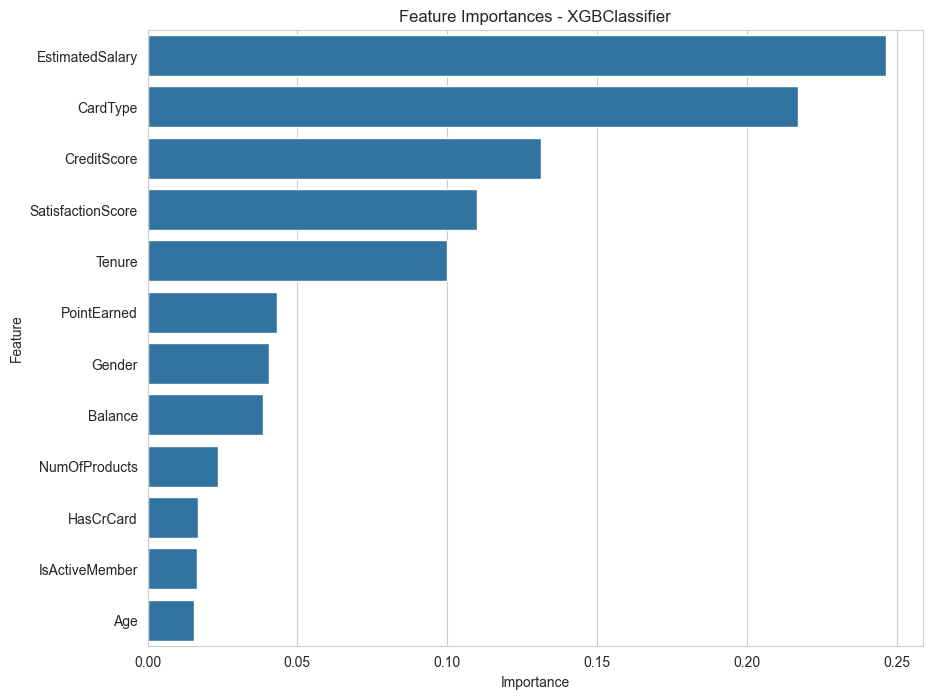

In [51]:
for model_name, feature_importances in feats_imp.items():
    plot_feature_importances(feature_importances, features_names, model_name)

#### Model evaluation

In [42]:
result_df_2 = pd.DataFrame({
    "Model name": names,
    "Accuracy": perf_dict.values()
})

result_df_2.set_index("Model name", inplace=True)
result_df_2

,Accuracy
Model name,
Logistic Regression,0.7115
Random Forest,0.8475
Gradient Boosting,0.8420
XGBoost,0.8430


## Tuned models

### Fitted models

#### Logistic Regression

In [53]:
c_grid = [0.01, 0.1, 1, 10, 100, 1000]
iter_grid = [100, 200, 300, 500]
class_w_grid = ['balanced', [{0: 1, 1: w} for w in [2, 4, 8, 16]]]

lr_param_grid = [
    {
        'log_classifier__solver': ['liblinear'],
        'log_classifier__penalty': ['l1', 'l2'],
        'log_classifier__C': c_grid,
        'log_classifier__max_iter': iter_grid,
        'log_classifier__class_weight': class_w_grid,
        'log_classifier__dual': [False],
    },
    {
        'log_classifier__solver': ['newton-cg', 'lbfgs', 'sag'],
        'log_classifier__penalty': ['l2', 'none'],
        'log_classifier__C': c_grid,
        'log_classifier__max_iter': iter_grid,
        'log_classifier__class_weight': class_w_grid,
    },
    {
        'log_classifier__solver': ['saga'],
        'log_classifier__penalty': ['elasticnet', 'l1', 'l2', 'none'],
        'log_classifier__C': c_grid,
        'log_classifier__max_iter': iter_grid,
        'log_classifier__l1_ratio': [0, 0.5, 1],  
        'log_classifier__class_weight': class_w_grid,
    }
]

lr_random_search = RandomizedSearchCV(logistic_reg_pipe, param_distributions=lr_param_grid, n_iter=100, cv=5, scoring="accuracy", random_state=42, n_jobs=-1)
lr_random_search.fit(X_train, y_train)
print(f'Best parameters: {lr_random_search.best_params_}')

/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty i

Best parameters: {'log_classifier__solver': 'newton-cg', 'log_classifier__penalty': 'l2', 'log_classifier__max_iter': 100, 'log_classifier__class_weight': 'balanced', 'log_classifier__C': 0.01}


/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty i

#### Random Forest

In [54]:
rf_param_grid = {
    'rf_classifier__n_estimators': [100, 200, 500, 1000],
    'rf_classifier__max_depth': [None] + [20, 30, 40, 50, 100],
    'rf_classifier__min_samples_split': randint(2, 20),
    'rf_classifier__min_samples_leaf': randint(1, 20),
    'rf_classifier__max_features': ['auto', 'sqrt', 'log2', None, 0.25, 0.5, 0.75],
    'rf_classifier__class_weight': ['balanced', 'balanced_subsample', [{0: 1, 1: w} for w in [2, 4, 8, 16]]],
    'rf_classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'rf_classifier__ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'rf_classifier__max_samples': [None] + list(np.linspace(0.1, 1, 10)),
    'rf_classifier__max_leaf_nodes': [None] + list(range(10, 100, 10)),
    'rf_classifier__min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

rf_random_search = RandomizedSearchCV(random_forest_pipe, param_distributions=rf_param_grid, n_iter=100, cv=5, scoring="accuracy", random_state=42, n_jobs=-1)
rf_random_search.fit(X_train, y_train)
print(f'Best parameters: {rf_random_search.best_params_}')

Best parameters: {'rf_classifier__ccp_alpha': 0.0, 'rf_classifier__class_weight': 'balanced_subsample', 'rf_classifier__criterion': 'entropy', 'rf_classifier__max_depth': 20, 'rf_classifier__max_features': 'log2', 'rf_classifier__max_leaf_nodes': None, 'rf_classifier__max_samples': 0.4, 'rf_classifier__min_impurity_decrease': 0.0, 'rf_classifier__min_samples_leaf': 17, 'rf_classifier__min_samples_split': 18, 'rf_classifier__n_estimators': 200}


#### Gradient Boosting

In [55]:
gb_param_grid = {
    'boost_classifier__n_estimators': [100, 200, 500, 1000],  
    'boost_classifier__learning_rate': uniform(0.01, 0.2),  
    'boost_classifier__max_depth': randint(3, 10),  
    'boost_classifier__min_samples_leaf': randint(1, 10),  
    'boost_classifier__max_features': ['sqrt', 'log2', None] + list(np.linspace(0.1, 0.9, 9)),
    'boost_classifier__subsample': [0.5, 0.75, 1.0],
    'boost_classifier__max_leaf_nodes': [None] + list(range(10, 100, 10)),
    'boost_classifier__min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'boost_classifier__validation_fraction': [0.1, 0.2, 0.3, 0.4, 0.5],
    'boost_classifier__n_iter_no_change': [5, 10, 15, 20],
    'boost_classifier__tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    'boost_classifier__ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'boost_classifier__criterion': ['friedman_mse', 'mse', 'mae'],
    'boost_classifier__loss': ['deviance', 'exponential']
}

gb_random_search = RandomizedSearchCV(gradient_boosting_pipe, param_distributions=gb_param_grid, n_iter=100, cv=5, scoring="accuracy", random_state=42, n_jobs=-1)
gb_random_search.fit(X_train, y_train)
print(f'Best parameters: {gb_random_search.best_params_}')

Best parameters: {'boost_classifier__ccp_alpha': 0.0, 'boost_classifier__criterion': 'friedman_mse', 'boost_classifier__learning_rate': 0.07703944832918018, 'boost_classifier__loss': 'exponential', 'boost_classifier__max_depth': 3, 'boost_classifier__max_features': 0.2, 'boost_classifier__max_leaf_nodes': 90, 'boost_classifier__min_impurity_decrease': 0.0, 'boost_classifier__min_samples_leaf': 3, 'boost_classifier__n_estimators': 500, 'boost_classifier__n_iter_no_change': 20, 'boost_classifier__subsample': 0.5, 'boost_classifier__tol': 0.0001, 'boost_classifier__validation_fraction': 0.3}


#### XGBoost

In [56]:
xgb_param_grid = {
    'xgb_classifier__n_estimators': [100, 200, 500, 1000],
    'xgb_classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb_classifier__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'xgb_classifier__min_child_weight': [1, 2, 4, 6, 8, 10],
    'xgb_classifier__subsample': [0.5, 0.75, 1.0],
    'xgb_classifier__colsample_bytree': [0.5, 0.75, 1.0],
    'xgb_classifier__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'xgb_classifier__reg_alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'xgb_classifier__reg_lambda': [1, 1.5, 2, 3, 4.5, 5],
    'xgb_classifier__scale_pos_weight': [1, 2, 4, 8, 16]
}

xgb_random_search = RandomizedSearchCV(xgb_pipe, param_distributions=xgb_param_grid, n_iter=100, cv=5, scoring="accuracy", random_state=42, n_jobs=-1)
xgb_random_search.fit(X_train, y_train)
print(f'Best parameters: {xgb_random_search.best_params_}')

Best parameters: {'xgb_classifier__subsample': 0.5, 'xgb_classifier__scale_pos_weight': 1, 'xgb_classifier__reg_lambda': 1.5, 'xgb_classifier__reg_alpha': 0.5, 'xgb_classifier__n_estimators': 100, 'xgb_classifier__min_child_weight': 10, 'xgb_classifier__max_depth': 7, 'xgb_classifier__learning_rate': 0.05, 'xgb_classifier__gamma': 0.4, 'xgb_classifier__colsample_bytree': 0.5}


### Model evaluation

In [57]:
tuned_params_dicts = [lr_random_search.best_params_, rf_random_search.best_params_, gb_random_search.best_params_, xgb_random_search.best_params_]

list_params_dict = get_params_for_model(tuned_params_dicts)

In [58]:
tuned_lg = LogisticRegression(**list_params_dict[0])
tuned_rf = RandomForestClassifier(**list_params_dict[1])
tuned_gb = GradientBoostingClassifier(**list_params_dict[2])
tuned_xgb = XGBClassifier(**list_params_dict[3])

In [59]:
tuned_models = [tuned_lg, tuned_rf, tuned_gb, tuned_xgb]

tuned_perf_dict, tuned_feats_imp = build_model(models, X_train_processed, X_test_processed, y_train, y_test)

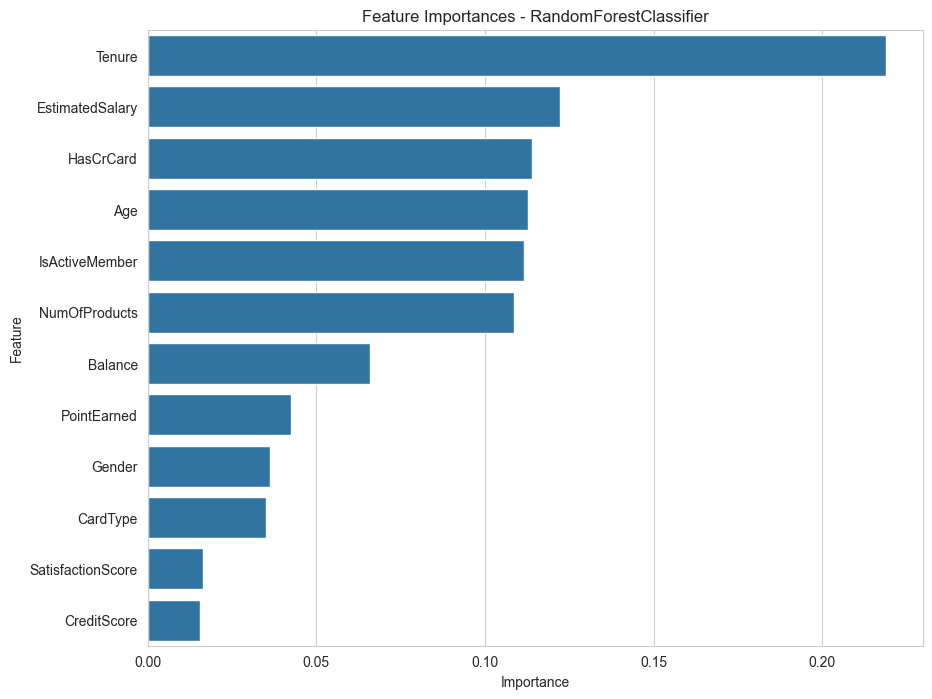

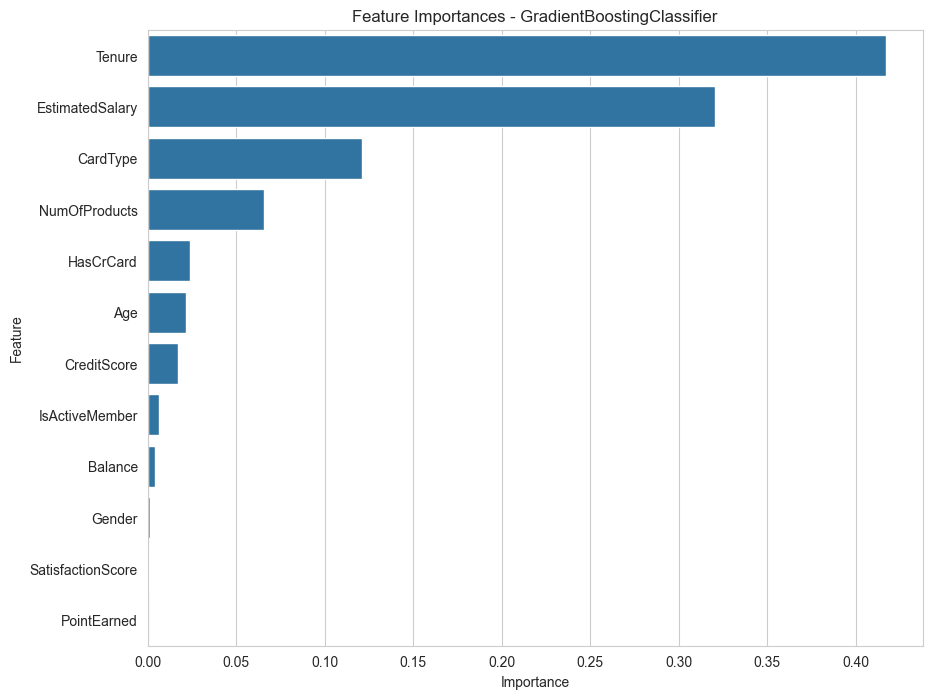

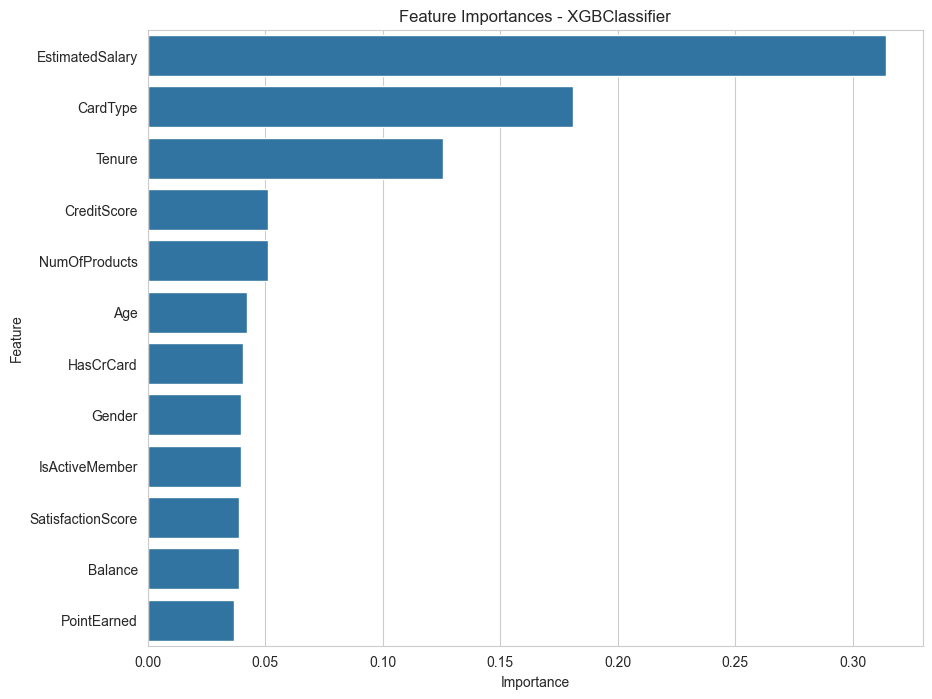

In [63]:
for model_name, feature_importances in tuned_feats_imp.items():
    plot_feature_importances(feature_importances, features_names, model_name)

In [60]:
tuned_result_df = pd.DataFrame({
    "Model name": names,
    "Accuracy": tuned_perf_dict.values()
})

tuned_result_df.set_index("Model name", inplace=True)
tuned_result_df

,Accuracy
Model name,
Logistic Regression,0.8045
Random Forest,0.8585
Gradient Boosting,0.8585
XGBoost,0.8440


> Comment: Decreased from the baseline models.

In [62]:
tuned_perf_dict_2, tuned_feats_imp_2 = build_model(models, X_train_resampled, X_test_processed, y_train_resampled, y_test)

tuned_result_df_2 = pd.DataFrame({
    "Model name": names,
    "Accuracy": tuned_perf_dict_2.values()
})

tuned_result_df_2.set_index("Model name", inplace=True)
tuned_result_df_2

,Accuracy
Model name,
Logistic Regression,0.7115
Random Forest,0.8475
Gradient Boosting,0.8420
XGBoost,0.8430


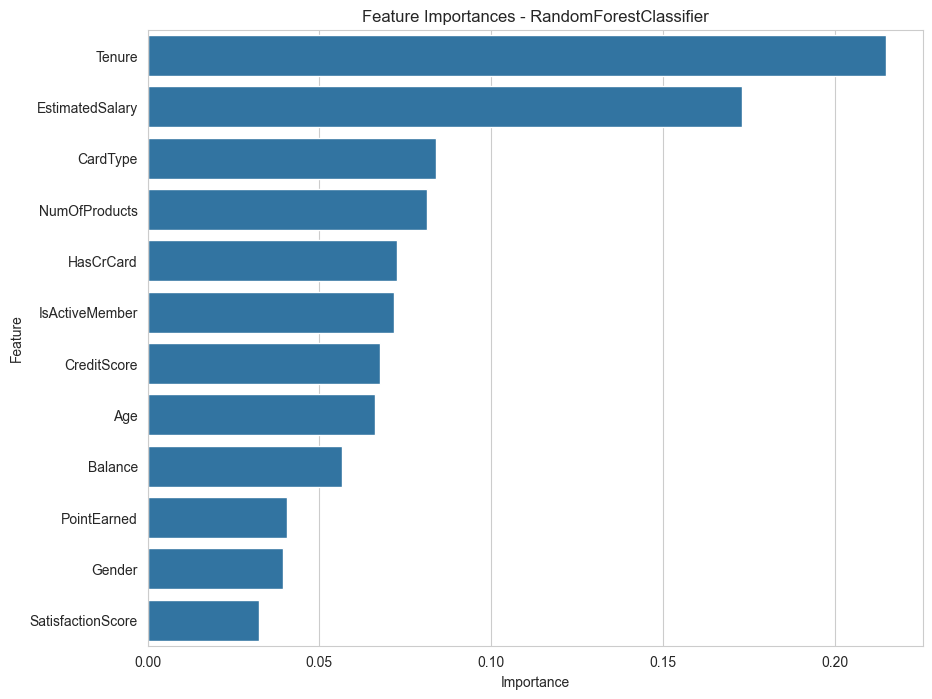

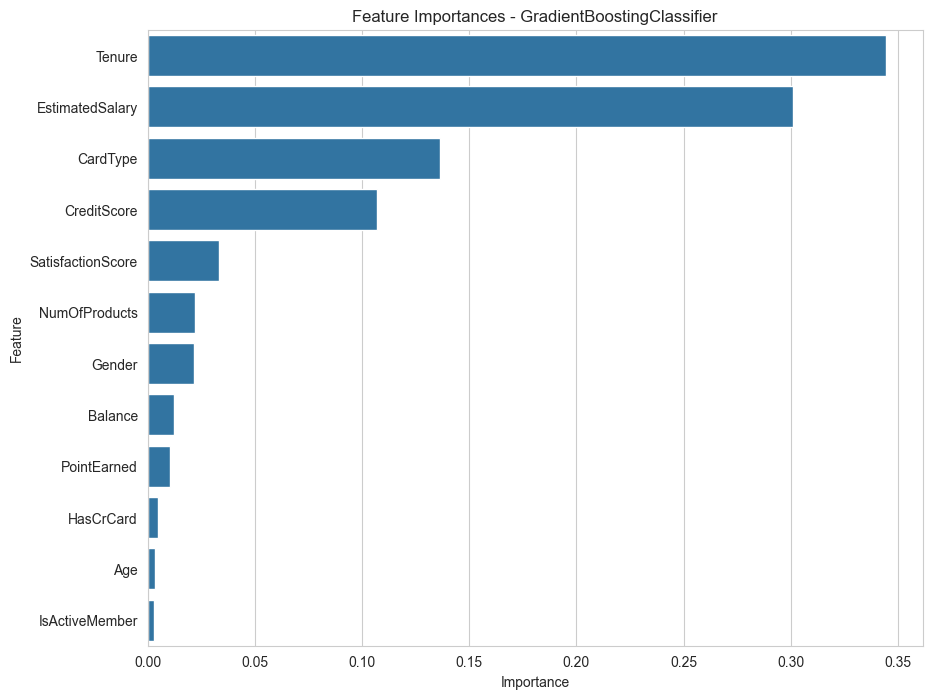

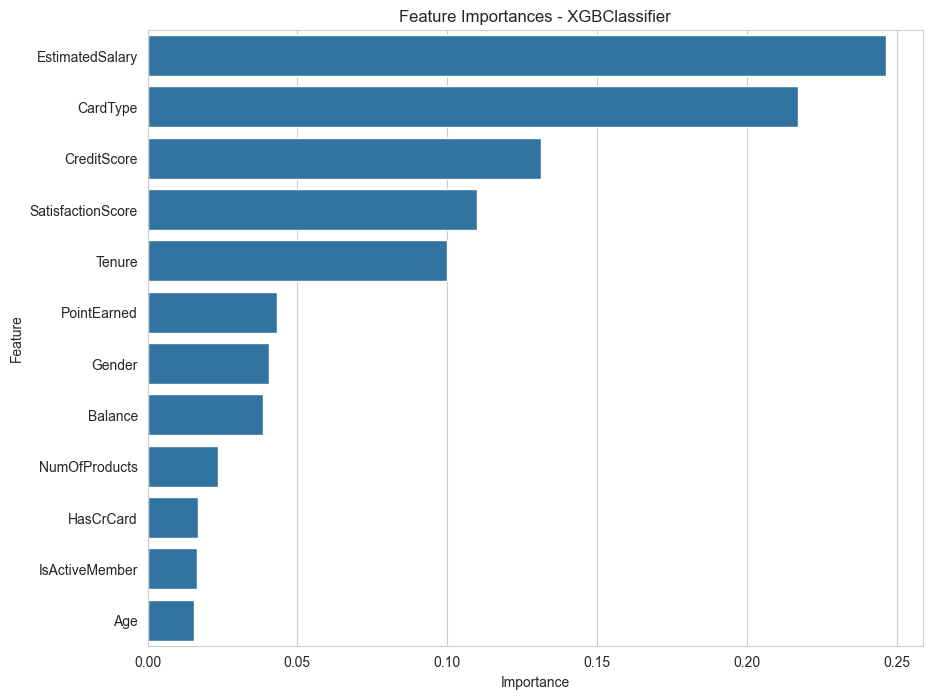

In [64]:
for model_name, feature_importances in tuned_feats_imp_2.items():
    plot_feature_importances(feature_importances, features_names, model_name)

# Select best model for Webapp

In [ ]:
gradient_boosting_pipe.fit(features, target)
joblib.dump(gradient_boosting_pipe, '../notebook/boosting_model.joblib')